In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

In [99]:
chRNA_psi = pd.read_csv('../code/QTLs/QTLTools/chRNA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')

In [ ]:
14829

In [19]:

for x in chRNA_psi.groupby('gid'):
    if x[1].shape[0] == 2:
        break

In [28]:
len_dif = []
max_psi = []
for x in chRNA_psi.groupby('gid'):
    if x[1].shape[0] == 2:
        len_dif.append(np.abs((x[1].iloc[1].end - x[1].iloc[1].start) - (x[1].iloc[0].end - x[1].iloc[0].start)))
        psi = x[1][x[1].columns[6:]].mean(axis=1).max()
        max_psi.append(psi)
        
len_dif = np.array(len_dif)
max_psi = np.array(max_psi)

In [29]:
df = pd.DataFrame()
df['len_dif'] = len_dif
df['symmetric'] = (len_dif%3)==0
df['max_psi'] = max_psi

In [53]:

df.loc[(df.max_psi <= 0.6) & (df.max_psi >= 0.5)].symmetric.mean()

0.43026941362916005

In [59]:
symmetric

[0.43026941362916005,
 0.4587378640776699,
 0.41524736415247365,
 0.4157973174366617,
 0.430062630480167,
 0.34812112986682503]

In [56]:
x = np.linspace(0.6, 1, 6)
symmetric = []
for i in x:
    symmetric.append(df.loc[(df.max_psi >= i-0.1) & (df.max_psi <= i)].symmetric.mean())

In [84]:
def is_alt(df):
    
    cassette_list = []
    len_dif_ = []
    delta_psi_ = []
    
    samples = df.columns[6:]
    
    any_cassette = False
    
    for idx, row in df.iterrows():
        
        if (row[samples].isna().mean()) < 0.1:
        
            start = row.start
            end = row.end
            
            psi = row[samples].mean()

            if (np.sum(df.start == start) == 2) & (np.sum((df.start == start) & (df.end < end)) == 1):
                I1 = df.loc[(df.start == start) & (df.end < end)]
#                 print(I1.shape)
                len_dif = np.abs((I1.end.iloc[0] - I1.start.iloc[0]) - (end-start))
#                 print(len_dif)
                I1_psi = I1[samples].mean(axis=1).iloc[0]
                delta_psi = np.abs(psi-I1_psi)
#                 print(delta_psi)
                len_dif_.append(len_dif)
                delta_psi_.append(delta_psi)
                
            if (np.sum(df.end == end) == 2) & (np.sum((df.end == end) & (df.start > start)) == 1):
                I1 = df.loc[(df.end == end) & (df.start > start)]
#                 print(I1.shape)
                len_dif = np.abs((I1.end.iloc[0] - I1.start.iloc[0]) - (end-start))
                I1_psi = I1[samples].mean(axis=1).iloc[0]
                delta_psi = np.abs(psi-I1_psi)
                
                len_dif_.append(len_dif)
                delta_psi_.append(delta_psi)
#         print(len(len_dif_))
                    
                
    return len_dif_, delta_psi_

#     return cassette_list
                    
    

In [100]:
len_dif = []
delta_psi = []

for x in tqdm(chRNA_psi.groupby('gid')):
    len_dif_, delta_psi_ = is_alt(x[1])
    len_dif.extend(len_dif_)
    delta_psi.extend(delta_psi_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49245/49245 [06:40<00:00, 123.02it/s]


In [101]:
df_chRNA = pd.DataFrame()
df_chRNA['len_dif'] = len_dif
df_chRNA['delta_psi'] = delta_psi
df_chRNA['symmetric'] = ((np.array(len_dif)%3)==0)

In [87]:
df = pd.DataFrame()
df['len_dif'] = len_dif
df['delta_psi'] = delta_psi
df['symmetric'] = ((np.array(len_dif)%3)==0)

In [117]:
df.loc[(df.delta_psi < 0.01)].symmetric.mean()

0.3437204910292729

In [116]:
df_chRNA.loc[(df_chRNA.delta_psi < 0.001)].symmetric.mean()

0.3242258652094718

(array([ 8912.,  3966.,  5185.,  6532.,  7993.,  5320.,  2425.,  2163.,
         3897., 11205.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

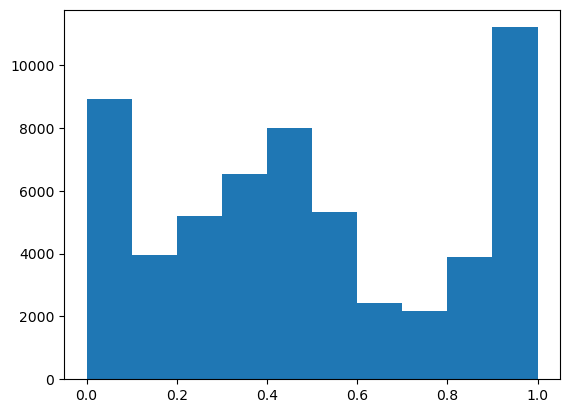

In [109]:
plt.hist(df_chRNA.delta_psi)

In [20]:
(x[1].start == x[1].start.min()).sum()

2

In [240]:
def is_cassette(df):
    
    cassette_list = []
    
    samples = df.columns[6:]
    
    any_cassette = False
    
    for idx, row in df.iterrows():
        
        if (row[samples].isna().mean()) < 0.1:
        
            start = row.start
            end = row.end

            if np.sum(df.start == start) >= 2:
                if np.sum(df.end == end) >= 2:
                    if np.sum((df.start == start) & (df.end <end).sum()>=1):
                        if np.sum((df.start > start) & (df.end == end).sum()>=1):
                            I1 = df.loc[(df.start == start) & (df.end < end)]
                            I2 = df.loc[(df.start > start) & (df.end == end)]

                            for idx_i1, row_i1 in I1.iterrows():
                                for idx_i2, row_i2 in I2.iterrows():
                                    if int(row_i1.end) < (int(row_i2.start)-2):
                                        
                                        length = int(row_i2.start) - int(row_i1.end) - 2
                                        
                                        cassette = (row.pid, row_i1.pid, row_i2.pid)
                                        
                                        psi_dif = np.abs(row_i1[samples] - row_i2[samples])
                                        psi_sum = (row_i1[samples] + row_i2[samples])>0
                                        
                                        if (np.mean(psi_dif) < 0.333) and (np.median(psi_sum)>0):
                                        
                                            PSI = np.mean(row_i1[samples] + row_i2[samples])

                                            cassette_list.append((cassette, PSI, length))

                                            any_cassette =  True

    return cassette_list
                    
    

In [241]:
cassette_list = []

for x in tqdm(chRNA_psi.groupby('gid')):
    cassette_list.extend(is_cassette(x[1]))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49245/49245 [04:41<00:00, 175.06it/s]


In [244]:
bins_1 = []
bins_2 = []
bins_3 = []
bins_4 = []
bins_5 = []
for exon in cassette_list:
#     print(exon[1])
#     print(exon[2])
    if (exon[1] < 0.2):
#         print('1')
        bins_1.append(exon[2]%3==0)
    elif (exon[1] < 0.4):
        bins_2.append(exon[2]%3==0)
    elif (exon[1] < 0.6):
        bins_3.append(exon[2]%3==0)
    elif (exon[1] < 0.8):
        bins_4.append(exon[2]%3==0)
    else:
        bins_5.append(exon[2]%3==0)

In [253]:
np.mean(bins_5)/0.33

1.148438338520983

In [166]:
bins_pct = [np.mean(x) for x in bins]

In [215]:
len(cassette_list)

21956

In [60]:
I1 = x[1].loc[(x[1].start == x[1].start.min()) & (x[1].end < x[1].end.max())]
I2 = x[1].loc[(x[1].start > x[1].start.min()) & (x[1].end == x[1].end.max())]
SE = x[1].loc[(x[1].start == x[1].start.min()) & (x[1].end == x[1].end.max())]

length_SE = int(SE.end) - int(SE.start)
exon_length = I2.start - I1.end
symmetric = (exon_length%3 == 0)

avg_PSI = np.nanmean(I1[x[1].columns[6:]] + I2[x[1].columns[6:]], axis=1)


/tmp/ipykernel_715461/1515007243.py:9: RuntimeWarning: Mean of empty slice
  avg_PSI = np.nanmean(I1[x[1].columns[6:]] + I2[x[1].columns[6:]], axis=1)


In [65]:
x[1]

,#Chr,start,end,pid,gid,strand,HG00096,HG00097,HG00099,HG00100,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
22123,chr10,38017015,38017291,10:38017015:38017291:clu_25065_+,chr10_clu_25065_+,+,0.923080,0.8913,0.970590,0.958330,...,0.903230,0.9375,0.87879,0.926830,0.83333,0.945950,0.941180,0.913040,0.935480,0.92
22124,chr10,38017015,38017312,10:38017015:38017312:clu_25065_+,chr10_clu_25065_+,+,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00
22125,chr10,38017020,38017291,10:38017020:38017291:clu_25065_+,chr10_clu_25065_+,+,0.076923,0.1087,0.029412,0.041667,...,0.096774,0.0625,0.12121,0.073171,0.16667,0.054054,0.058824,0.086957,0.064516,0.08


In [68]:
((x[1].start == x[1].start.min()) & (x[1].end == x[1].end.max())).sum()

1